note : **MODELS 3-5 ARE THE BEST MODELS EVERYTHING ELSE EITHER OVERFITS OR UNDERFITS** 🔔



**Private school model** on whether a school is open or closed

revisions on previous model:
- try multiple ways to classify how many schools are closed..
- think about feature engineering instead of removing multicolinearity... (transform or log variables)
- 2 year prediction horizon








⏰ ***plan***   to handle 2 year horizon of closing.. ⏰

intead of keeping all of the years that a closed school was open only keep the previous 2 before it closed... this will introduce a new group of schools that are on the way to closing and are not closed yet.. the model will likely predict these schools to be closed even though they are still open and we will learn that they are high risk and need to be considered for financing and aid.

⏰ ***plan*** to handle classification of how schools are considered closed... ⏰

try multiple ways and see which way makes the most sense to the models

⏰ ***plan*** to handle  feature engineering and multicolinearity ⏰

Make a random forest classifier and use the top 30-40 variables predictive of the target..

create heatmaps to visualize multicolinearity

feature engineer new features by combining highly correalted features instead of dropping features from the dataset

In [ ]:
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
#loading in the private school datasets
data_2015 = pd.read_csv("f1415_f3.csv")
data_2016 = pd.read_csv("f1516_f3.csv")
data_2017 = pd.read_csv("f1617_f3.csv")
data_2018 = pd.read_csv("f1718_f3.csv")
data_2019 = pd.read_csv("f1819_f3.csv")
data_2020 = pd.read_csv("f1920_f3.csv")
data_2021 = pd.read_csv("f2021_f3.csv")
data_2022 = pd.read_csv("f2122_f3.csv")
data_2023 = pd.read_csv("f2223_f3.csv")

In [ ]:
#create the year variable and merge the dataframes...
data_2015["year"] = 2015
data_2016["year"] = 2016
data_2017["year"] = 2017
data_2018["year"] = 2018
data_2019["year"] = 2019
data_2020["year"] = 2020
data_2021["year"] = 2021
data_2022["year"] = 2022
data_2023["year"] = 2023

In [ ]:
total_data = pd.concat([data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022, data_2023], axis = 0)

total_data = total_data.dropna(axis = 1)

total_data #heres all of the shared columns

,UNITID,XF3A01,XF3A01A,XF3A01B,XF3A01C,XF3A02,XF3A02A,XF3A03,XF3A04,XF3A05,...,F3E073,XF3E075,F3E075,XF3E076,F3E076,XF3E077,F3E077,XF3F01,XF3F02,year
0,101116,R,Z,R,R,R,Z,R,R,Z,...,761356,R,494957,Z,0,R,5812531,R,R,2015
1,101277,A,A,A,A,A,A,A,A,A,...,34779,R,17275,R,344,R,116608,A,A,2015
2,101365,R,R,R,R,R,R,R,R,R,...,275951,R,119625,Z,0,R,1964953,A,A,2015
3,101958,R,R,R,R,R,R,R,R,R,...,143518,R,0,R,0,R,483170,A,A,2015
4,102845,R,R,R,R,R,R,R,R,R,...,3052459,R,1922877,R,477,R,27549495,R,R,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,499547,A,A,A,A,A,A,A,A,A,...,15853,R,16752,R,6012,R,0,A,A,2023
2086,499556,A,A,A,A,A,A,A,A,A,...,0,R,15322,Z,0,R,107610,A,A,2023
2087,499608,A,A,A,A,A,A,A,A,A,...,0,R,0,R,0,R,57070,A,A,2023
2088,499680,R,R,R,R,R,R,R,R,R,...,0,R,0,R,0,R,8200,A,A,2023


In [ ]:
#decide how to create the target variable open or closed... (here i am using the last year it appears inside the dataset)
def create_target_column(data):
    # Find the last year each UNITID appears
    last_year_open = data.groupby("UNITID")["year"].max().reset_index()
    last_year_open.rename(columns={'year': 'last_year_open'}, inplace=True)

    # Merge the last_year_open column back into the original data
    data = data.merge(last_year_open, on="UNITID", how="left")

    # Create the target column and initialize it to 0
    data["target"] = 0

    # Set target = 1 for rows where the year matches the last_year_open
    # EXCEPT for UNITIDs that appear in 2023
    data.loc[(data["year"] == data["last_year_open"]) &
             (~data["UNITID"].isin(data[data["year"] == 2023]["UNITID"])), "target"] = 1

    # Drop the last_year_open column as it's no longer needed
    data.drop(columns=["last_year_open"], inplace=True)

    return data

In [ ]:
data = create_target_column(total_data)

In [ ]:
data["target"].value_counts() #1411 closures

,count
target,
0,20322
1,1411


In [ ]:
#creating numerical data frame
n_data = data.select_dtypes(include =["number"])

In [ ]:
from sklearn.model_selection import train_test_split

X = n_data.drop(["target"], axis = 1)
y = n_data["target"]

from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify= y)
#stratify makes sure the class distribution is the same in the training and testsets

rf_model = RandomForestClassifier(n_estimators = 100, random_state =42, class_weight = "balanced")
rf_model.fit(X_train, y_train)

feature_names = X.columns
feature_importance = pd.Series(rf_model.feature_importances_, index = feature_names)
sorted_feature_importance = feature_importance.sort_values(ascending = False)

print(sorted_feature_importance.head(20))

year       0.081614
F3E03C1    0.056091
F3D01      0.054141
F3D06      0.053677
F3D09      0.051684
F3E012     0.049362
UNITID     0.048325
F3E077     0.046974
F3E011     0.045545
F3E03A1    0.044607
F3E075     0.044107
F3E071     0.044094
F3E072     0.042177
F3E03B1    0.040494
F3E03C2    0.040319
F3E03B2    0.038353
F3E03A2    0.037434
F3E073     0.036188
F3E061     0.029949
F3D08      0.022711
dtype: float64


Text(0.5, 1.0, 'when are schools closing?')

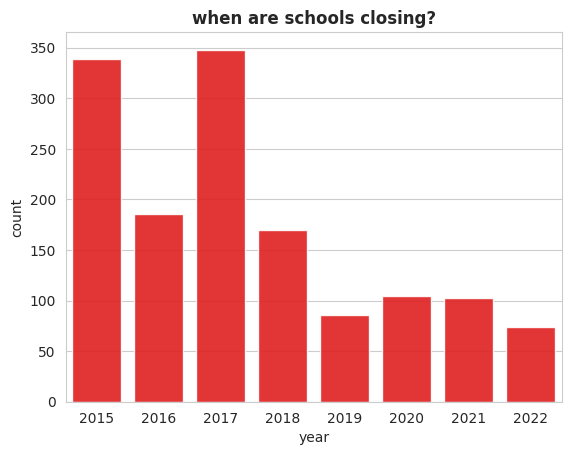

In [ ]:
#interestingly knowing the year is the strongest predictor to closures.. i wonder if this is becuase of covid
sns.set_style("whitegrid")
sns.countplot(data = n_data[n_data["target"]==1], x = "year", color = "red", alpha = 0.9)
plt.title("when are schools closing?", fontdict={"weight" : "bold"})

In [ ]:
#it seems like more schools cloesd prior to 2019 for some reason
#maybe due to bidens $750 Billion plan in 2020 to fund schools and students tution?

In [ ]:
sorted_feature_importance.head(20).index # 20 most important featuers

Index(['year', 'F3E03C1', 'F3D01', 'F3D06', 'F3D09', 'F3E012', 'UNITID',
       'F3E077', 'F3E011', 'F3E03A1', 'F3E075', 'F3E071', 'F3E072', 'F3E03B1',
       'F3E03C2', 'F3E03B2', 'F3E03A2', 'F3E073', 'F3E061', 'F3D08'],
      dtype='object')

In [ ]:
filtered_data = n_data[['target', 'year', 'F3E03C1', 'F3D01', 'F3D06', 'F3D09', 'F3E012',
       'F3E077', 'F3E011', 'F3E03A1', 'F3E075', 'F3E071', 'F3E072', 'F3E03B1',
       'F3E03C2', 'F3E03B2', 'F3E03A2', 'F3E073', 'F3E061', 'F3D08']]

In [ ]:
filtered_data #top 19 features and target variable

,target,year,F3E03C1,F3D01,F3D06,F3D09,F3E012,F3E077,F3E011,F3E03A1,F3E075,F3E071,F3E072,F3E03B1,F3E03C2,F3E03B2,F3E03A2,F3E073,F3E061,F3D08
0,0,2015,3979582,7517792,0,11503337,2064095,5812531,3468102,616719,494957,11025416,3956572,2554240,413285,1030376,381395,761356,0,0
1,0,2015,320304,708888,150333,859565,166228,116608,188360,0,17275,552742,383736,44078,176592,40916,0,34779,0,0
2,0,2015,498829,3787123,0,3924007,787610,1964953,1790955,250933,119625,4081978,1721449,1541261,170923,527197,205523,275951,0,136884
3,0,2015,475070,1162678,0,1162678,441649,483170,728497,84011,0,1386040,759352,22969,317703,0,0,143518,75493,0
4,0,2015,7888454,54673626,56886,54860519,6450946,27549495,16283154,2133891,1922877,48105162,15579854,16589085,899348,6689792,1370922,3052459,5210578,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21728,0,2023,198999,738578,0,738578,109276,0,469106,66037,16752,768553,242837,34411,84993,18213,30355,15853,0,0
21729,0,2023,98991,68616,0,68616,0,107610,35941,3000,15322,182488,12000,3000,6000,3000,3000,0,41556,0
21730,0,2023,51529,176800,12597,189397,81439,57070,81439,51529,0,190038,81439,5541,0,0,0,0,0,0
21731,0,2023,0,0,0,0,0,8200,0,0,0,134500,121300,0,0,0,0,0,134500,0


In [ ]:
#need to create a new train_test_split on the filtered dataset
X = filtered_data.drop(["target"], axis = 1)
y = filtered_data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify= y)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler #this will hopefully detect the outliers and realize they are closed schools

#scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)



LogisticRegression()

In [ ]:
probs = model.predict_proba(X_test_scaled)
preds = model.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6706
           1       0.00      0.00      0.00       466

    accuracy                           0.94      7172
   macro avg       0.47      0.50      0.48      7172
weighted avg       0.87      0.94      0.90      7172

[[6706    0]
 [ 466    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'probility closed preds from logistic regression')

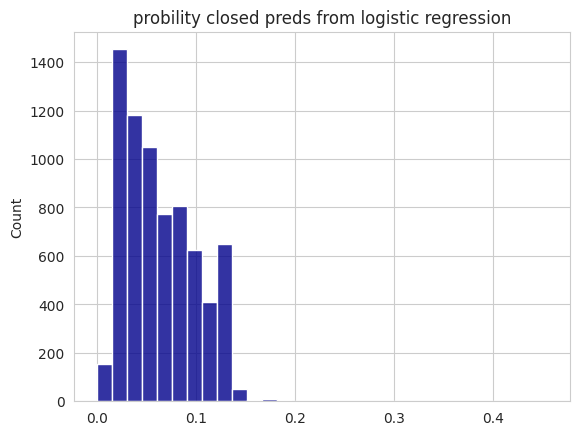

In [ ]:
prob_closed = probs[:, 1]
sns.histplot(prob_closed, color = "darkblue", alpha = 0.8, bins = 30)
plt.title("probility closed preds from logistic regression")
#for some reason the predictions to be closed are lower.. maybe less features is better and im introducing too much noise

#i think this model has too much noise so ill try building tensorflow models to better handle the feature weights instead of doing feature selection on the logistic regression

In [ ]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation = "relu"),
    tf.keras.layers.Dense(5, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
history_1 = model_1.fit(X_train_scaled, y_train, epochs = 50, verbose = 1)

Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8058 - loss: 0.5363
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9337 - loss: 0.2469
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9357 - loss: 0.2351
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9348 - loss: 0.2312
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9352 - loss: 0.2309
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9358 - loss: 0.2262
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9361 - loss: 0.2260
Epoch 8/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9354 - loss: 0.2252
Epoch 9/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9336 - loss: 0.2303
Epoch 10/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9336 - loss: 0.2264
Epoch 11/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9358 - loss: 0.2204
Epoch 12/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Text(0.5, 1.0, 'model isnt strong enough to break .2 loss')

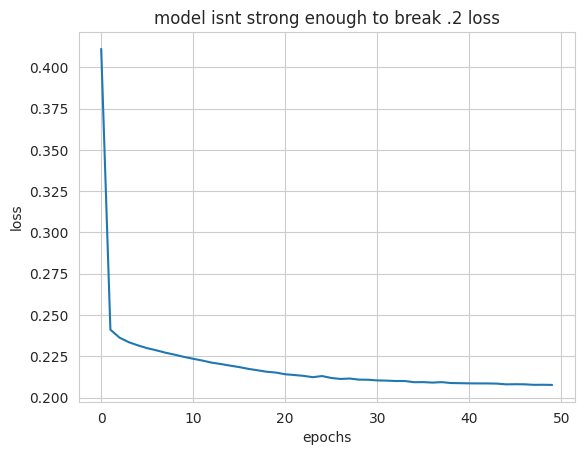

In [ ]:
plt.plot(history_1.history["loss"], label = "training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("model isnt strong enough to break .2 loss")

In [ ]:
#model one was a flop and failed to improve from the second epoch... ill try increasing the number of neurons
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_2 = model_2.fit(X_train_scaled, y_train, epochs = 20, verbose = 1)


Epoch 1/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8489 - loss: 0.4515
Epoch 2/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9366 - loss: 0.2293
Epoch 3/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9338 - loss: 0.2265
Epoch 4/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9372 - loss: 0.2192
Epoch 5/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9361 - loss: 0.2206
Epoch 6/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9387 - loss: 0.2136
Epoch 7/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9363 - loss: 0.2159
Epoch 8/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9345 - loss: 0.2198
Epoch 9/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9337 - loss: 0.2187
Epoch 10/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9363 - loss: 0.2105
Epoch 11/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9347 - loss: 0.2170
Epoch 12/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Text(0.5, 1.0, 'with more epochs it might be able to achieve a lower loss')

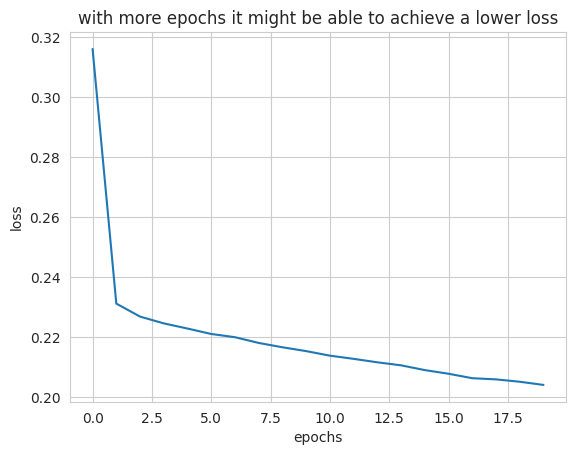

In [ ]:
plt.plot(history_2.history["loss"], label = "training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("with more epochs it might be able to achieve a lower loss")

In [ ]:
#the stronger model discovered slightly more and was able to break through 94% accuracy

#this model simulates if the model above was trained on 200 epochs:
#what we found is that the model is not learned signicantly more with a higher learning rate and the same epochs,
#signaling that the neurons and layers may need to be increased

#for model 3 ill try the exact same model with a faster learning rate
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_3.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = ["accuracy"]
)

history_3 = model_3.fit(X_train_scaled, y_train, epochs = 20, verbose = 1)

Epoch 1/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9332 - loss: 0.2575
Epoch 2/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9332 - loss: 0.2419
Epoch 3/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9391 - loss: 0.2146
Epoch 4/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9355 - loss: 0.2197
Epoch 5/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9334 - loss: 0.2180
Epoch 6/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9354 - loss: 0.2118
Epoch 7/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9387 - loss: 0.2024
Epoch 8/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9349 - loss: 0.2141
Epoch 9/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9394 - loss: 0.1986
Epoch 10/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9353 - loss: 0.2140
Epoch 11/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9406 - loss: 0.2032
Epoch 12/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Text(0.5, 1.0, 'loss smashes through 0.2')

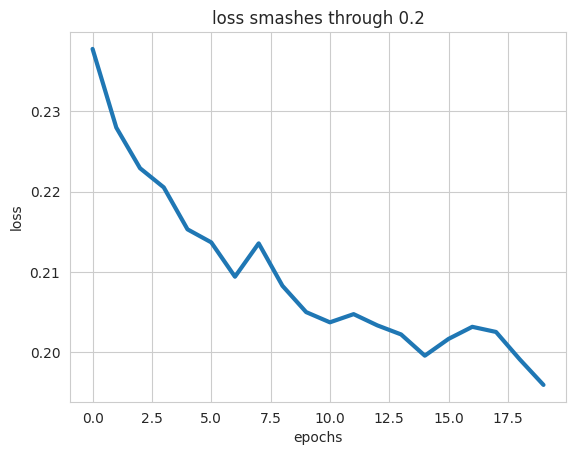

In [ ]:
#loss is less smooth because the learning rate is high but the model is continuing to learn and would likely preform better on more epochs
plt.plot(history_3.history["loss"], label = "training loss", lw = 3)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss smashes through 0.2")

In [ ]:
#checking what the probabilities look like and the minority class detection before enhancing the model further:
model_3_probs = model_3.predict(X_test_scaled)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
model_3_probs

array([[0.08474386],
       [0.01346184],
       [0.05563923],
       ...,
       [0.04545561],
       [0.04754817],
       [0.06418389]], dtype=float32)

Text(0.5, 1.0, 'model_3 is starting to find closed school patterns')

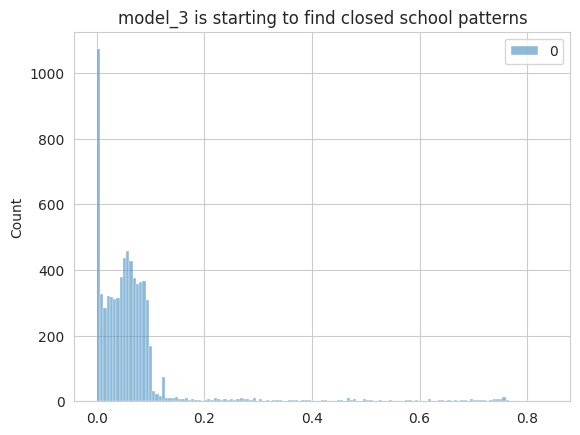

In [ ]:
sns.histplot(model_3_probs) #looks like this model is predicting some schools as closed.. going to check the confusion matrix
plt.title("model_3 is starting to find closed school patterns")

In [ ]:
y_preds = [1 if pred > 0.5 else 0 for pred in model_3_probs]

In [ ]:
print(confusion_matrix(y_test, y_preds))
#doing beteter at catching the closed schools!! but still missing too many

#could easily lower the classification threshold but lets try to make the tensorflow model as strong as possible first

[[6647   59]
 [ 374   92]]


In [ ]:
#creating a stronger model to see if it predicts closures better:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation= "relu"),
    tf.keras.layers.Dense(40, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_4.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.01),
    metrics = ["accuracy"]
)

In [ ]:
history_4 = model_4.fit(X_train_scaled, y_train, epochs = 40, verbose= 1)

Epoch 1/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9333 - loss: 0.2576
Epoch 2/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9320 - loss: 0.2370
Epoch 3/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9344 - loss: 0.2235
Epoch 4/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9349 - loss: 0.2161
Epoch 5/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9372 - loss: 0.2115
Epoch 6/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9399 - loss: 0.2086
Epoch 7/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9422 - loss: 0.2015
Epoch 8/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9375 - loss: 0.2142
Epoch 9/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9403 - loss: 0.2042
Epoch 10/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9408 - loss: 0.2091
Epoch 11/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9393 - loss: 0.2121
Epoch 12/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

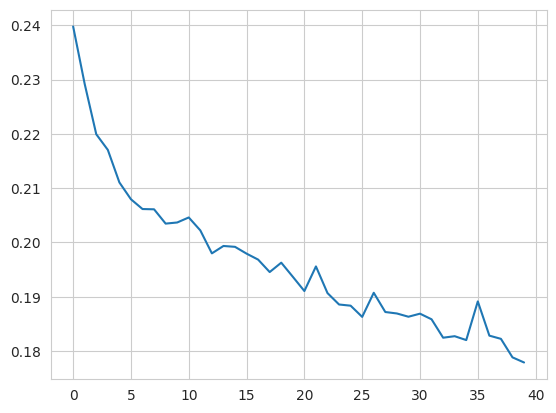

In [ ]:
#was able to get loss lower
plt.plot(history_4.history["loss"])

In [ ]:
#building the strongest model yet
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(60, activation = "relu"),
    tf.keras.layers.Dense(60, activation= "relu"),
    tf.keras.layers.Dense(40, activation= "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_5.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.01),
    metrics= ["accuracy"]
)

history_5 = model_5.fit(X_train_scaled, y_train, epochs =40, verbose = 1)

Epoch 1/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9354 - loss: 0.2647
Epoch 2/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9378 - loss: 0.2235
Epoch 3/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9369 - loss: 0.2199
Epoch 4/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9346 - loss: 0.2301
Epoch 5/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9417 - loss: 0.2064
Epoch 6/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9388 - loss: 0.2153
Epoch 7/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9398 - loss: 0.2186
Epoch 8/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9388 - loss: 0.2122
Epoch 9/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9393 - loss: 0.2117
Epoch 10/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9425 - loss: 0.2117
Epoch 11/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9447 - loss: 0.1977
Epoch 12/40
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Text(0.5, 1.0, 'not really any better than the previous model')

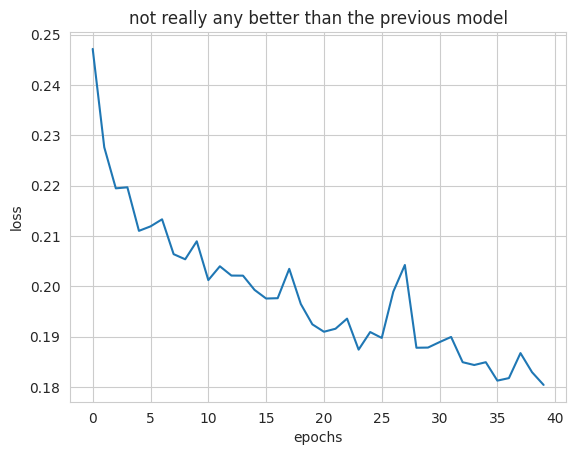

In [ ]:
plt.plot(history_5.history["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("not really any better than the previous model")
#although it seems like its continuing to improve.. ill run the same model with 80 epochs as model 6

In [ ]:
#asme as model 5 but with 2x the epochs
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(60, activation = "relu"),
    tf.keras.layers.Dense(60, activation= "relu"),
    tf.keras.layers.Dense(40, activation= "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_5.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.01),
    metrics= ["accuracy"]
)

history_6 = model_5.fit(X_train_scaled, y_train, epochs =80, verbose = 1)

Epoch 1/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9495 - loss: 0.1888
Epoch 2/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9462 - loss: 0.1854
Epoch 3/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9526 - loss: 0.1792
Epoch 4/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9461 - loss: 0.1863
Epoch 5/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9476 - loss: 0.1812
Epoch 6/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9484 - loss: 0.1783
Epoch 7/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9477 - loss: 0.1795
Epoch 8/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9512 - loss: 0.1721
Epoch 9/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9426 - loss: 0.1976
Epoch 10/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9506 - loss: 0.1737
Epoch 11/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9499 - loss: 0.1733
Epoch 12/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Text(0.5, 1.0, 'best model yet but very volitile results')

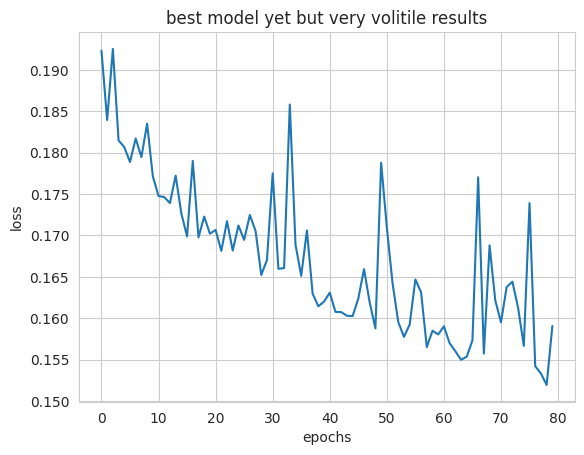

In [ ]:
plt.plot(history_6.history["loss"], label = "training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("best model yet but very volitile results")

In [ ]:
#going to create model 7 where the learning rate is 3x slower and trained on more epochs to have a more gradual slope..

#model 7 will also have slightly more neurons and one more layer

#ill also over shoot the 3x increase on the epochs to have more opportunity to learn

model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(80, activation = "relu"),
    tf.keras.layers.Dense(60, activation= "relu"),
    tf.keras.layers.Dense(40, activation= "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_5.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0033),
    metrics= ["accuracy"]
)

history_7 = model_5.fit(X_train_scaled, y_train, epochs =320, verbose = 1)

Epoch 1/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9564 - loss: 0.1529
Epoch 2/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9630 - loss: 0.1330
Epoch 3/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9563 - loss: 0.1489
Epoch 4/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9595 - loss: 0.1401
Epoch 5/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9585 - loss: 0.1405
Epoch 6/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9630 - loss: 0.1331
Epoch 7/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9597 - loss: 0.1403
Epoch 8/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9562 - loss: 0.1444
Epoch 9/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9629 - loss: 0.1304
Epoch 10/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9564 - loss: 0.1436
Epoch 11/320
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9619 - loss: 0.1341
Epoch 12/320
456/456 ━━━━━━━━━━━━━━━━━━━━

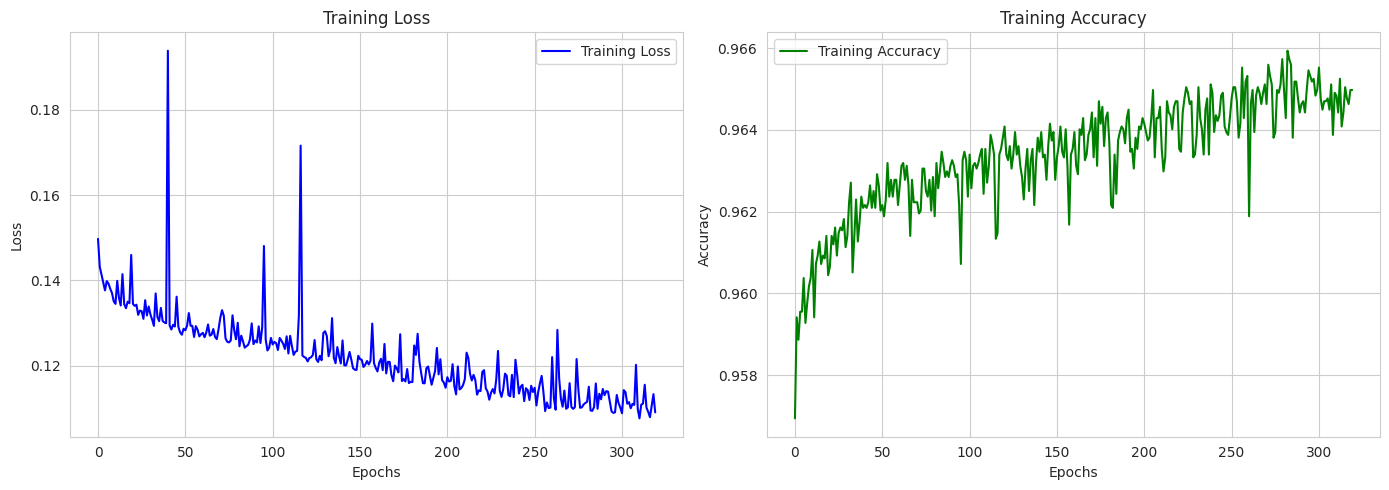

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot the training loss on the first subplot
axs[0].plot(history_7.history["loss"], label="Training Loss", color="blue")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].legend()

# Plot the training accuracy on the second subplot
axs[1].plot(history_7.history["accuracy"], label="Training Accuracy", color="green")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training Accuracy")
axs[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

#accuracy really went nowhere, loss continues to improve

In [ ]:
#checking the predictions of model 7
model_7_preds = model_7.predict(X_test_scaled)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Axes: ylabel='Count'>

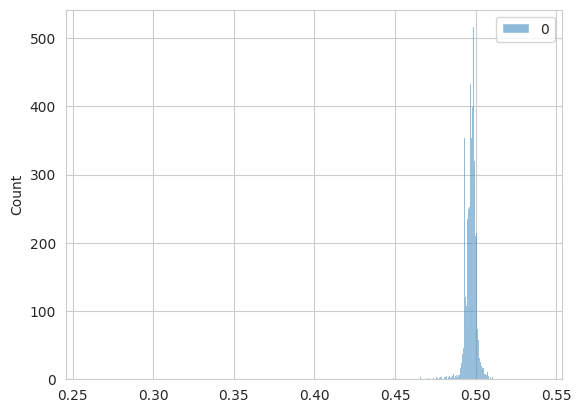

In [ ]:
sns.histplot(model_7_preds) #looks like the model is overfitting dramatically compared to 3 making almost every school the same prediction

In [ ]:
#model 3 was the best model so i will create model 8 to mimic model 3 and include the class weights parameter

model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_8.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = ["accuracy"]
)

from sklearn.utils import class_weight
import numpy as np

# Assuming y_train is a 1D array or list of labels:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


history_8 = model_8.fit(X_train_scaled, y_train, epochs = 20, verbose = 1, class_weight = class_weight_dict)

Epoch 1/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4930 - loss: 0.6904
Epoch 2/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5571 - loss: 0.6327
Epoch 3/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6269 - loss: 0.6221
Epoch 4/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6291 - loss: 0.6014
Epoch 5/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6722 - loss: 0.6122
Epoch 6/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6721 - loss: 0.6124
Epoch 7/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6109 - loss: 0.6200
Epoch 8/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6349 - loss: 0.5999
Epoch 9/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7020 - loss: 0.5623
Epoch 10/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6684 - loss: 0.5728
Epoch 11/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6557 - loss: 0.5872
Epoch 12/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Text(0.5, 1.0, 'looking like the kind of distribution we want')

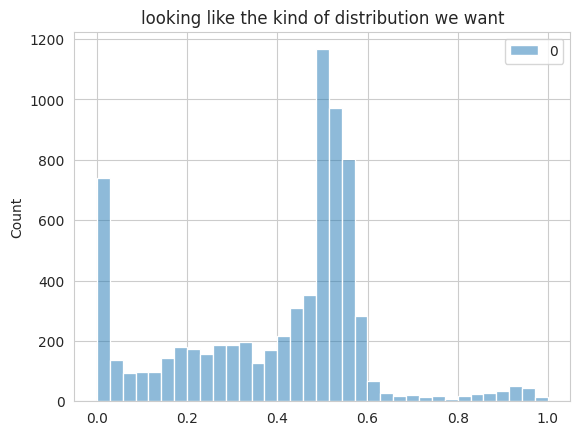

In [ ]:
model_8_preds = model_8.predict(X_test_scaled)
sns.histplot(model_8_preds)
plt.title("looking like the kind of distribution we want")

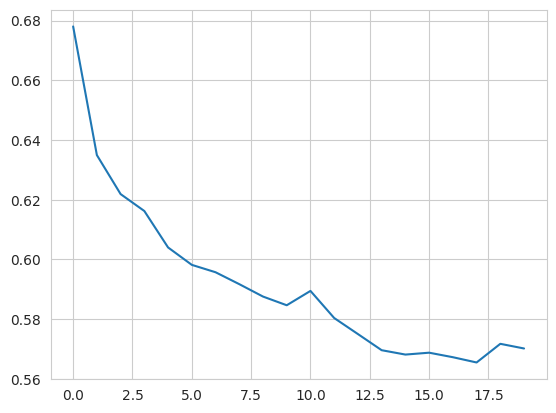

In [ ]:
plt.plot(history_8.history["loss"]) #looks like a solid model

In [ ]:
model_8_pred_classes = [1 if pred > 0.15 else 0 for pred in model_8_preds]

In [95]:
print(confusion_matrix(y_test, model_8_pred_classes)) #missing 104 cloesd schools is not good

#catching almost all of the schools with a .15 threshold.. while this misclassifies a bunch of schools as closed, we can split those into groups based on thier risk

[[1201 5505]
 [   5  461]]


In [96]:
#going to try to improve upon this model by doubling neurons
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation = "relu"),
    tf.keras.layers.Dense(40, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_9.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = ["accuracy"]
)

history_9 = model_9.fit(X_train_scaled, y_train, epochs = 20, verbose = 1, class_weight = class_weight_dict)

Epoch 1/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5750 - loss: 0.6964
Epoch 2/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6239 - loss: 0.6490
Epoch 3/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6102 - loss: 0.6319
Epoch 4/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7071 - loss: 0.6120
Epoch 5/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6721 - loss: 0.6058
Epoch 6/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6214 - loss: 0.6146
Epoch 7/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6546 - loss: 0.6136
Epoch 8/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7105 - loss: 0.5975
Epoch 9/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7862 - loss: 0.6089
Epoch 10/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6776 - loss: 0.5679
Epoch 11/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6614 - loss: 0.5898
Epoch 12/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Text(0.5, 1.0, 'model 9 is better but plateaus')

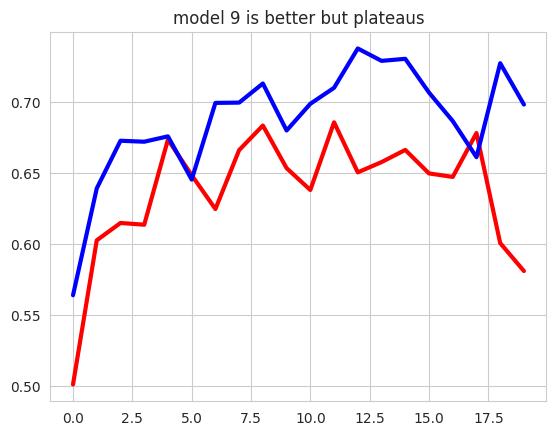

In [98]:
#compaing model 8 to model 9
plt.plot(history_8.history["accuracy"], color = "r", lw = 3)
plt.plot(history_9.history["accuracy"], color = "b", lw = 3)
plt.title("model 9 is better but plateaus")

In [99]:
model_9_preds = model_9.predict(X_test_scaled)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Axes: ylabel='Count'>

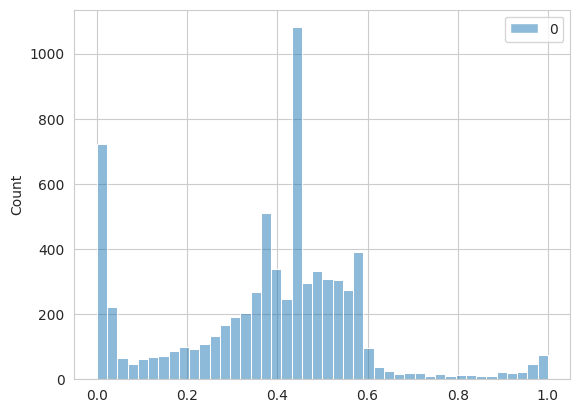

In [100]:
sns.histplot(model_9_preds)

In [107]:
model_9_pred_classes = [1 if pred > 0.1 else 0 for pred in model_9_preds]

In [108]:
confusion_matrix(y_test, model_9_pred_classes) #actually model 9 is worse than model 8.. it overfits and misses more open schools

array([[1082, 5624],
       [   5,  461]])

In [109]:
#maybe the best approach is to create a weaker model.

#or using the class weight parameter is not actually the best to determine how similar schools are to closed beacuse the buld of the distrubution becomes
#centered instead of the natural skew

#going to build model 10 with the goal of limiting model complexity

model_10 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation= "relu"),
    tf.keras.layers.Dense(10, activation= "relu"),
    tf.keras.layers.Dense(1, activation = "relu")
])

model_10.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = ["accuracy"]
)

history_10 = model_10.fit(X_test_scaled, y_test, epochs = 20, verbose = 1)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9222 - loss: 0.6662
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9372 - loss: 0.2790
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9364 - loss: 0.2509
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9333 - loss: 0.2644
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9372 - loss: 0.2665
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9339 - loss: 0.2337
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9327 - loss: 0.2700
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9363 - loss: 0.2285
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9331 - loss: 0.2328
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9370 - loss: 0.2209
Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9366 - loss: 0.2275
Epoch 12/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [110]:
model_10_preds = model_10.predict(X_test_scaled)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Axes: ylabel='Count'>

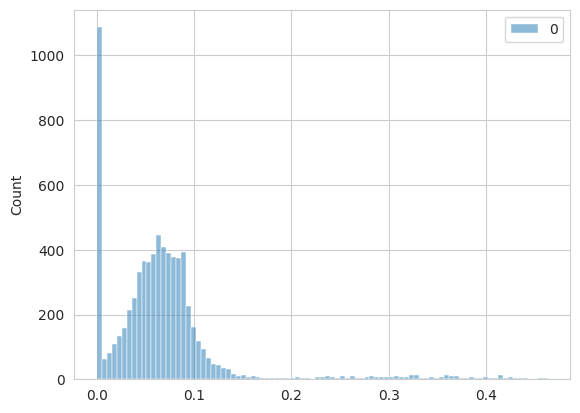

In [111]:
sns.histplot(model_10_preds)

In [126]:
model_10_predicted_classes = [1 if pred > 0.1 else 0 for pred in model_10_preds]

In [127]:
confusion_matrix(y_test, model_10_predicted_classes)

array([[5968,  738],
       [ 299,  167]])

In [ ]:
#this model is too simple its really not even realizing the closed class exists since preds only go up to ~.45

#overall models 3-5 are the best everything else is either too simple or too complex